In [1]:
#%matplotlib inline
import argparse
import os
import random
import pickle
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import tqdm

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


# MANGA Dataset
---

### Preprocessing

In [3]:
# Training and Validation data
transforms = v2.Compose([
    v2.Resize((64, 64)), # Resize to 224x224
    v2.ToTensor(),
    v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), # Normalize
])

# Create Datasets for Training and Validation
PATH = '../animeface-character-dataset/animeface-character-dataset' 
train_dataset = ImageFolder(PATH, transform=transforms)

In [4]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 9754
    Root location: ../animeface-character-dataset/animeface-character-dataset
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [5]:
# Create a DataLoader for batching and shuffling the data
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Generator
---

In [6]:
class Generator(nn.Module):
    def __init__(self, maps = 64, noise_size = 128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(noise_size, maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.ReLU(True),
            # state size. (maps*8) x 4 x 4
            nn.ConvTranspose2d(maps * 8, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.ReLU(True),
            # state size. (maps*4) x 8 x 8
            nn.ConvTranspose2d(maps * 4, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.ReLU(True),
            # state size. (maps*2) x 16 x 16
            nn.ConvTranspose2d(maps * 2, maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps),
            nn.ReLU(True),
            # state size. (maps) x 32 x 32
            nn.ConvTranspose2d(maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


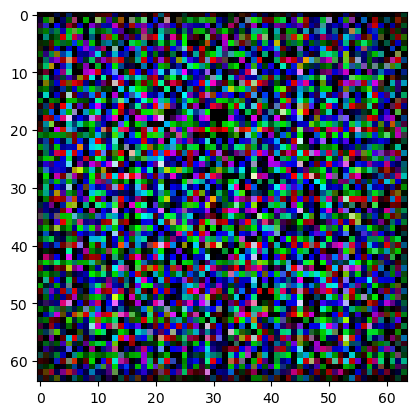

In [7]:
generator = Generator()
noise = torch.randn(64, 128, 1, 1)
output = generator(noise)
plt.imshow(output[0].detach().numpy().transpose(1, 2, 0))
plt.show()

# Discriminator
---

In [8]:
class Discriminator(nn.Module):
    def __init__(self, maps = 64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(3, maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps) x 32 x 32
            nn.Conv2d(maps, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*2) x 16 x 16
            nn.Conv2d(maps * 2, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*4) x 8 x 8
            nn.Conv2d(maps * 4, maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*8) x 4 x 4
            nn.Conv2d(maps * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [9]:
# Instantiate the discriminator
discriminator = Discriminator()
output_discriminator = discriminator(output)
output_discriminator.shape

torch.Size([64, 1])

In [10]:
output.shape

torch.Size([64, 3, 64, 64])

# Compiler
---

In [12]:
generator = Generator()
discriminator = Discriminator()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()


# Training Loop
num_epochs = 10
latent_size = 128

for epoch in tqdm.tqdm(range(num_epochs)):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images
        batch_size = real_images.size(0)

        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train the generator
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_size, 1, 1)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Train the discriminator
        d_optimizer.zero_grad()
        real_outputs = discriminator(real_images)
        d_real_loss = criterion(real_outputs, real_labels)
        fake_outputs = discriminator(fake_images.detach())
        d_fake_loss = criterion(fake_outputs, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")

# Save the model checkpoints
with open('generator.pkl', 'wb') as f:
    pickle.dump(generator, f)

with open('discriminator.pkl', 'wb') as f:
    pickle.dump(discriminator, f)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/305], Generator Loss: 12.5268, Discriminator Loss: 1.2581
Epoch [1/10], Step [200/305], Generator Loss: 2.3685, Discriminator Loss: 0.3455
Epoch [1/10], Step [300/305], Generator Loss: 2.2446, Discriminator Loss: 0.3582


 10%|█         | 1/10 [12:05<1:48:49, 725.54s/it]

Epoch [2/10], Step [100/305], Generator Loss: 0.6061, Discriminator Loss: 1.1130
Epoch [2/10], Step [200/305], Generator Loss: 2.7324, Discriminator Loss: 0.3779
Epoch [2/10], Step [300/305], Generator Loss: 1.4342, Discriminator Loss: 0.6169


 20%|██        | 2/10 [24:30<1:38:13, 736.69s/it]

Epoch [3/10], Step [100/305], Generator Loss: 2.0346, Discriminator Loss: 0.2391
Epoch [3/10], Step [200/305], Generator Loss: 2.3276, Discriminator Loss: 0.2067
Epoch [3/10], Step [300/305], Generator Loss: 2.3655, Discriminator Loss: 0.2430


 30%|███       | 3/10 [36:52<1:26:14, 739.17s/it]

Epoch [4/10], Step [100/305], Generator Loss: 1.5021, Discriminator Loss: 0.5563
Epoch [4/10], Step [200/305], Generator Loss: 7.8213, Discriminator Loss: 1.4051
Epoch [4/10], Step [300/305], Generator Loss: 6.4268, Discriminator Loss: 0.7519


 40%|████      | 4/10 [48:38<1:12:37, 726.17s/it]

Epoch [5/10], Step [100/305], Generator Loss: 2.6571, Discriminator Loss: 0.2222
Epoch [5/10], Step [200/305], Generator Loss: 1.0827, Discriminator Loss: 0.7543
Epoch [5/10], Step [300/305], Generator Loss: 3.8230, Discriminator Loss: 0.1965


 50%|█████     | 5/10 [1:00:33<1:00:10, 722.05s/it]

Epoch [6/10], Step [100/305], Generator Loss: 8.0884, Discriminator Loss: 0.7189
Epoch [6/10], Step [200/305], Generator Loss: 3.1328, Discriminator Loss: 0.2629
Epoch [6/10], Step [300/305], Generator Loss: 2.3223, Discriminator Loss: 0.3167


 60%|██████    | 6/10 [1:12:31<48:03, 720.79s/it]  

Epoch [7/10], Step [100/305], Generator Loss: 4.0537, Discriminator Loss: 0.2335
Epoch [7/10], Step [200/305], Generator Loss: 2.4409, Discriminator Loss: 0.4165
Epoch [7/10], Step [300/305], Generator Loss: 3.4154, Discriminator Loss: 0.8869


 70%|███████   | 7/10 [1:30:39<42:02, 840.89s/it]

Epoch [8/10], Step [100/305], Generator Loss: 3.9436, Discriminator Loss: 0.4607
Epoch [8/10], Step [200/305], Generator Loss: 3.4807, Discriminator Loss: 0.2839
Epoch [8/10], Step [300/305], Generator Loss: 3.1318, Discriminator Loss: 0.1935


 80%|████████  | 8/10 [1:44:28<27:54, 837.05s/it]

Epoch [9/10], Step [100/305], Generator Loss: 1.6542, Discriminator Loss: 0.4124
Epoch [9/10], Step [200/305], Generator Loss: 0.4656, Discriminator Loss: 1.3659
Epoch [9/10], Step [300/305], Generator Loss: 4.2060, Discriminator Loss: 0.2311


 90%|█████████ | 9/10 [1:57:07<13:32, 812.75s/it]

Epoch [10/10], Step [100/305], Generator Loss: 1.6215, Discriminator Loss: 0.6391
Epoch [10/10], Step [200/305], Generator Loss: 3.4114, Discriminator Loss: 0.2033
Epoch [10/10], Step [300/305], Generator Loss: 2.6652, Discriminator Loss: 0.2091


100%|██████████| 10/10 [2:09:42<00:00, 778.22s/it]


# Model Evaluation
---

## Random Noise

In [13]:
generator = pickle.load(open('generator.pkl', 'rb'))

torch.Size([4, 128, 1, 1])


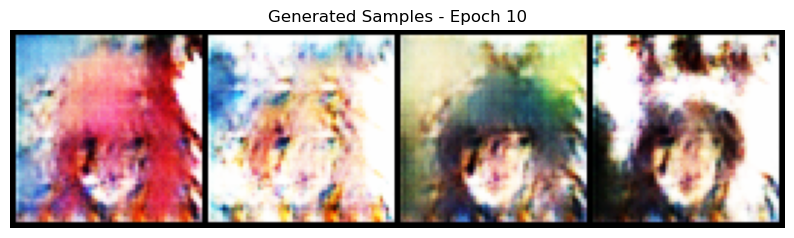

In [14]:
# Generate samples for visualization
with torch.no_grad():
    z = torch.randn(4, latent_size, 1, 1)
    print(z.shape)
    fake_samples = generator(z).reshape(-1, 3, 64, 64)
    # fake_samples = (fake_samples + 1) / 2
    
# Visualize generated samples
grid_img = vutils.make_grid(fake_samples, nrow=4, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch {epoch+1}")
plt.show()

## Real Images - ResNet50

In [15]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# Load and preprocess the image
img_path = "../animeface-character-dataset/data/face_0_119_15.png"
img = Image.open(img_path)

# Resize the image to match the expected input size of the CNN model
resize_transform = transforms.Resize((224, 224))
img_resized = resize_transform(img)

# Convert the image to a tensor and normalize it
to_tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_tensor = normalize_transform(to_tensor_transform(img_resized)).unsqueeze(0)

# Load a pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# Set the model to evaluation mode
resnet.eval()

# Extract features from the image using the ResNet model
with torch.no_grad():
    features = resnet(img_tensor)

# Use a linear layer to reduce the number of channels to 128
linear_layer = torch.nn.Linear(in_features=features.size(1), out_features=128)
features_reduced = linear_layer(features.squeeze()).unsqueeze(-1).unsqueeze(-1)

# Add an extra dimension at the beginning
features_reduced = features_reduced.unsqueeze(0)

# Further processing or use of the feature map
print(features_reduced.shape)  # Output: torch.Size([1, 128, 1, 1])


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/adityanair/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 33.1MB/s]


torch.Size([1, 128, 1, 1])


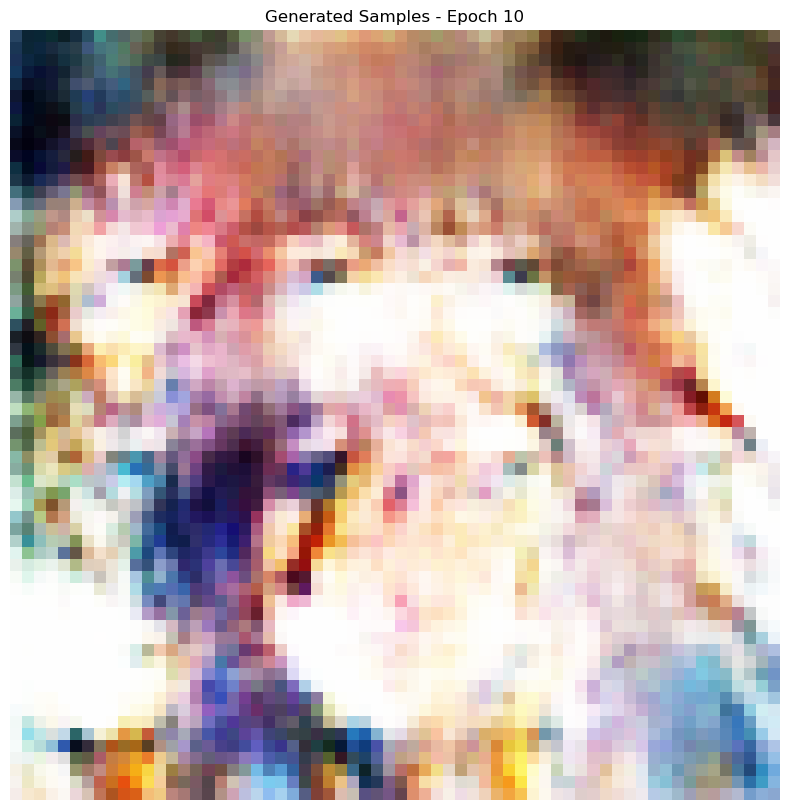

In [16]:
fake_samples = generator(features_reduced).reshape(-1, 3, 64, 64)
# Visualize generated samples
grid_img = vutils.make_grid(fake_samples, nrow=4, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch {epoch+1}")
plt.show()